In [2]:
pip install wordcloud


Note: you may need to restart the kernel to use updated packages.


In [5]:
pip install --upgrade Pillow


  Attempting uninstall: Pillow
    Found existing installation: Pillow 8.0.1
    Uninstalling Pillow-8.0.1:
      Successfully uninstalled Pillow-8.0.1
Note: you may need to restart the kernel to use updated packages.


Content-Based Recommended Products:
      reviewerID  asin                 reviewText     summary
3638        1962     0                 No issues.  Five Stars
3741        1809     0                      Great  Five Stars
3234        2855     0                       good  Five Stars
2791         348     0                Works great  Five Stars
582         3318     0  fast and giv, works great  Five Stars
Precision: 1.0
Recall: 1.0
F1-Score: 1.0


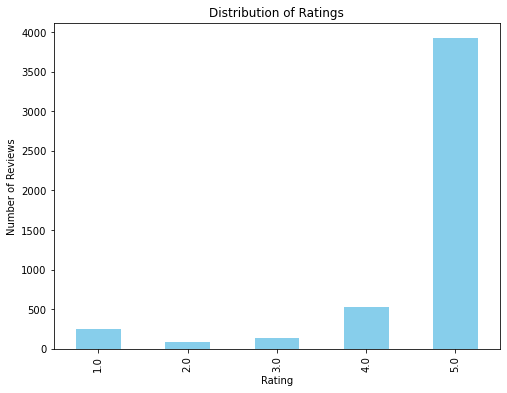

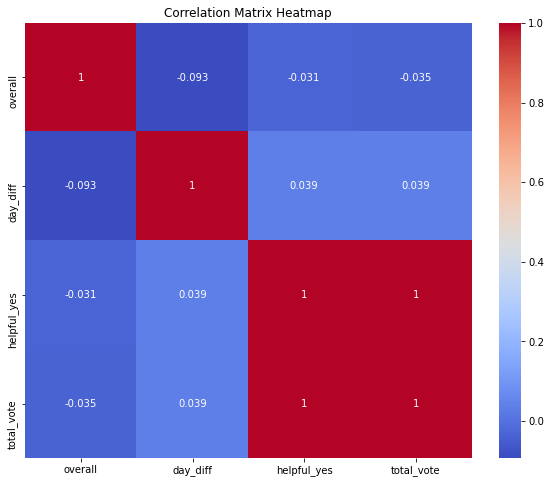

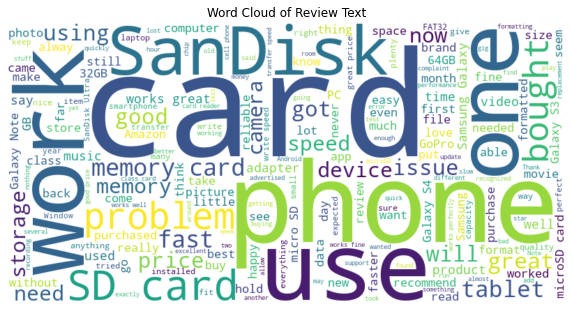

In [1]:
import pandas as pd
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.metrics import precision_score, recall_score, f1_score, accuracy_score
from sklearn.model_selection import train_test_split
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from wordcloud import WordCloud

# Step 1: Load the dataset
file_path = 'amazon_review.csv'  # Using the file path  locally
new_data = pd.read_csv(file_path)

# Step 2: Data Preprocessing
# Drop rows with missing 'reviewerID', 'asin', or 'overall' values
new_data_cleaned = new_data.dropna(subset=['reviewerID', 'asin', 'overall'])

# Convert 'reviewerID' and 'asin' to categorical codes
new_data_cleaned['reviewerID'] = new_data_cleaned['reviewerID'].astype('category').cat.codes
new_data_cleaned['asin'] = new_data_cleaned['asin'].astype('category').cat.codes

# Combine review text and summary for better feature representation
new_data_cleaned['combined_text'] = new_data_cleaned['reviewText'].fillna('') + " " + new_data_cleaned['summary'].fillna('')

# Step 3: Content-Based Filtering using TF-IDF
# Feature Extraction using TF-IDF
tfidf = TfidfVectorizer(stop_words='english', max_features=5000)
tfidf_matrix = tfidf.fit_transform(new_data_cleaned['combined_text'])

# Step 4: Calculate Cosine Similarity
cosine_sim = cosine_similarity(tfidf_matrix, tfidf_matrix)

# Step 5: Function to get recommendations based on content similarity
def get_content_recommendations(product_index, cosine_sim=cosine_sim):
    # Get similarity scores for all products with the given product
    sim_scores = list(enumerate(cosine_sim[product_index]))
    # Sort the products based on similarity scores
    sim_scores = sorted(sim_scores, key=lambda x: x[1], reverse=True)
    # Get the indices of the most similar products (excluding itself)
    sim_scores = sim_scores[1:6]  # Get top 5 similar products
    # Get the product indices
    product_indices = [i[0] for i in sim_scores]
    return new_data_cleaned.iloc[product_indices]

# Example: Get recommendations for the first product in the dataset
example_product_index = 0
content_recommended_products = get_content_recommendations(example_product_index)

# Display the recommended products using standard print
print("Content-Based Recommended Products:")
print(content_recommended_products[['reviewerID', 'asin', 'reviewText', 'summary']])

# Model Evaluation: Precision, Recall, F1-Score
# For simplicity, we'll consider a recommendation relevant if its rating is 4 or higher
def evaluate_model(product_index, k=5):
    recommended_products = get_content_recommendations(product_index)
    true_labels = (recommended_products['overall'] >= 4).astype(int)  # Binary relevance (1 for relevant, 0 for not)
    predicted_labels = [1] * k  # Assume all recommended items are predicted as relevant
    
    precision = precision_score(true_labels, predicted_labels)
    recall = recall_score(true_labels, predicted_labels)
    f1 = f1_score(true_labels, predicted_labels)
    
    return precision, recall, f1

# Calculate Precision, Recall, and F1 for the example product
precision, recall, f1 = evaluate_model(example_product_index, k=5)
print(f"Precision: {precision}")
print(f"Recall: {recall}")
print(f"F1-Score: {f1}")

# Step 6: Visualization
# 1. Distribution of Ratings
plt.figure(figsize=(8, 6))
new_data_cleaned['overall'].value_counts().sort_index().plot(kind='bar', color='skyblue')
plt.title('Distribution of Ratings')
plt.xlabel('Rating')
plt.ylabel('Number of Reviews')
plt.show()

# 2. Heatmap of Correlation Matrix
plt.figure(figsize=(10, 8))
correlation_matrix = new_data_cleaned[['overall', 'day_diff', 'helpful_yes', 'total_vote']].corr()
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm')
plt.title('Correlation Matrix Heatmap')
plt.show()

# 3. Word Cloud for Review Text
all_text = ' '.join(new_data_cleaned['reviewText'].fillna('').values)
wordcloud = WordCloud(width=800, height=400, background_color='white').generate(all_text)
plt.figure(figsize=(10, 6))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.title('Word Cloud of Review Text')
plt.show()

# Optional: User Interaction for getting recommendations
def user_input_recommendation():
    user_input = input("Enter the product index (0 to {}): ".format(len(new_data_cleaned) - 1))
    try:
        user_input = int(user_input)
        if 0 <= user_input < len(new_data_cleaned):
            recommendations = get_content_recommendations(user_input)
            print("Recommendations based on product index {}: ".format(user_input))
            print(recommendations[['reviewerID', 'asin', 'reviewText', 'summary']])
        else:
            print("Invalid index. Please enter a number between 0 and {}.".format(len(new_data_cleaned) - 1))
    except ValueError:
        print("Invalid input. Please enter a numeric index.")

# Uncomment the following line to enable user interaction
# user_input_recommendation()
